In [1]:
# Sign into tahoesw
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

**Step 1**
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

dirname = "drive/My Drive/colab data/camera_cal/"

# prepare object points
nx = 9 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((ny * nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(dirname + "calib*.jpg")

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = dirname + 'corners_found'+ str(idx) + '.jpg'
        cv2.imwrite(write_name, img)
        #plt.imshow(img)
        #plt.show()

drive/My Drive/colab data/camera_cal/calibration2.jpg
drive/My Drive/colab data/camera_cal/calibration14.jpg
drive/My Drive/colab data/camera_cal/calibration6.jpg
drive/My Drive/colab data/camera_cal/calibration3.jpg
drive/My Drive/colab data/camera_cal/calibration11.jpg
drive/My Drive/colab data/camera_cal/calibration13.jpg
drive/My Drive/colab data/camera_cal/calibration8.jpg
drive/My Drive/colab data/camera_cal/calibration12.jpg
drive/My Drive/colab data/camera_cal/calibration7.jpg
drive/My Drive/colab data/camera_cal/calibration9.jpg
drive/My Drive/colab data/camera_cal/calibration10.jpg
drive/My Drive/colab data/camera_cal/calibration16.jpg
drive/My Drive/colab data/camera_cal/calibration20.jpg
drive/My Drive/colab data/camera_cal/calibration17.jpg
drive/My Drive/colab data/camera_cal/calibration15.jpg
drive/My Drive/colab data/camera_cal/calibration19.jpg
drive/My Drive/colab data/camera_cal/calibration18.jpg


### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

Text(0.5, 1.0, 'Undistorted Image')

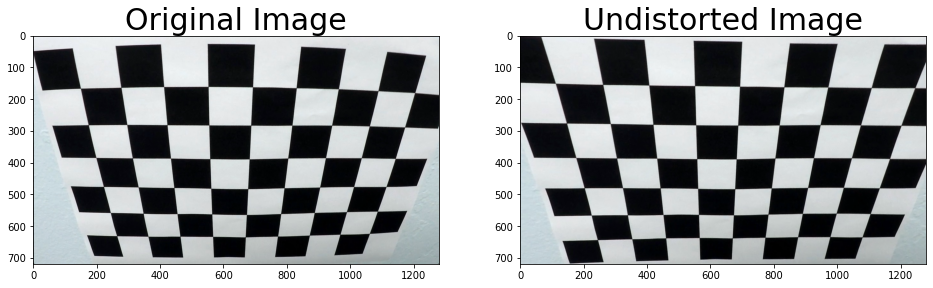

In [3]:
# calibrate, calculate distortion coefficients & save to pickle
import pickle
%matplotlib inline

img = cv2.imread(dirname + 'calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open(dirname + "wide_dist_pickle.p", "wb" ) )

# Test undistortion on an image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(dirname + 'test_undist.jpg', dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

**Step 2**
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.


In [0]:
# Threshold functions
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        return 0
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    #thresh_min = 20
    #thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #binary_output = np.copy(img) # Remove this line
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    mag = np.sqrt(sobelx * sobelx + sobely * sobely)
    # Rescale to 8 bit
    #scale_factor = np.max(mag)/255 
    mag = (mag / (np.max(mag) / 255)).astype(np.uint8)
    binary_output = np.zeros_like(mag)
    binary_output[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    # 6) Return this mask as your binary_output image
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def color_threshold(img, sthresh=(0, 255), vthresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S > sthresh[0]) & (S <= sthresh[1])] = 1
    #binary_output = np.copy(img) # placeholder line

    # 1) Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the V channel
    V = hsv[:,:,2]
    # 3) Return a binary image of threshold result
    v_channel_output = np.zeros_like(V)
    v_channel_output[(V > vthresh[0]) & (V <= vthresh[1])] = 1
    #binary_output = np.copy(img) # placeholder line

    output = np.zeros_like(S)
    output[(binary_output == 1) & (v_channel_output  == 1)] = 1
    return output

In [0]:
def window_mask(width, height, img_ref, center, level):
  output = np.zeros_like(img_ref)
  output[int(img_ref.shape[0] - (level+1) * height) : int(img_ref.shape[0] - level * height),
         max(0,int(center-width)) : min(int(center+width), img_ref.shape[1])] = 1
  return output

In [0]:
def warp_transform(img, out_img):
  # define perspective transformation area

  '''
  width = img.shape[1]
  height = img.shape[0]

  bot_width =.72
  mid_width = .08
  height_pct = .62
  bottom_trim = .935

  fudge = 20
  corner1 = [img.shape[1] * (.5 - mid_width/2) + fudge*2, img.shape[0]*height_pct]
  corner2 = [img.shape[1] * (.5 + mid_width) + fudge, img.shape[0]*height_pct]
  corner3 = [img.shape[1] * (.5 + bot_width/2) + fudge, img.shape[0]*bottom_trim]
  corner4 = [img.shape[1] * (.5 - bot_width/2) + fudge*2, img.shape[0]*bottom_trim]
  corner1 = [width * (0.5 - mid_width / 2), height * height_pct]
  corner2 = [width * (0.5 + mid_width / 2), height * height_pct]
  corner3 = [width * (0.5 + bot_width / 2), height * bottom_trim]
  corner4 = [width * (0.5 - bot_width / 2), height * bottom_trim]
  src = np.float32([corner1, corner2, corner3, corner4])

  corner1 = [width * .2, 0]
  corner2 = [width * .8, 0]
  corner3 = [width * .8, height]
  corner4 = [width * .2, height]
  dst = np.float32([corner1, corner2, corner3, corner4])
  '''  
  # perspective transform constants
  img_size = (img.shape[1], img.shape[0])
  offset_x = 300
  offset_y = 0
  width = img.shape[1]
  height = img.shape[0]

  # source and destination points (top left, top right, bottom right, bottom left)
  top_left = [595, 450]
  top_right = [685, 450]
  bottom_left = [1000, 660]
  bottom_right = [280, 660]

  src = np.float32([top_left, top_right, bottom_left, bottom_right])

  dst = np.float32([[offset_x, offset_y], 
                    [img_size[0]-offset_x, offset_y],
                    [img_size[0]-offset_x, img_size[1]-offset_y],
                    [offset_x, img_size[1]-offset_y]])


  M = cv2.getPerspectiveTransform(src, dst)
  Minv = cv2.getPerspectiveTransform(dst, src)

  warp_xform = cv2.warpPerspective(out_img, M, (width, height), flags=cv2.INTER_LINEAR)
  warp_xform = cv2.warpPerspective(out_img, M, img_size, flags=cv2.INTER_LINEAR)

  return warp_xform, M, Minv

In [0]:
def find_window_centroids(warp_xform):
  
  margin = 40
  smooth_factor = 100
  
  window_centroids = []
  window = np.ones(window_width)
  
  l_sum = np.sum(warp_xform[int(3*warp_xform.shape[0]/4):,:int(warp_xform.shape[1]/2)], axis=0)
  l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
  r_sum = np.sum(warp_xform[int(3*warp_xform.shape[0]/4):,int(warp_xform.shape[1]/2):], axis=0)
  r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + int(warp_xform.shape[1]/2)
  
  window_centroids.append((l_center, r_center))
  
  for level in range(1, (int)(warp_xform.shape[0]/window_height)):
    image_layer = np.sum(warp_xform[int(warp_xform.shape[0] - (level+1)*window_height):int(warp_xform.shape[0]-level*window_height),:], axis=0)
    conv_signal = np.convolve(window, image_layer)
    
    offset = window_width/2
    l_min_index = int(max(l_center + offset - margin, 0))
    l_max_index = int(min(l_center + offset + margin, warp_xform.shape[1]))
    l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
    
    r_min_index = int(max(r_center + offset - margin, 0))
    r_max_index = int(min(r_center + offset + margin, warp_xform.shape[1]))
    r_center = np.argmax(conv_signal[r_min_index: r_max_index]) + r_min_index - offset
    
    window_centroids.append((l_center, r_center))
    
  recent_centers.append(window_centroids)
  
  return np.average(recent_centers[-smooth_factor:], axis = 0)


In [0]:
def detect_lines(warp_xform, window_centroids):

    l_points = np.zeros_like(warp_xform)
    r_points = np.zeros_like(warp_xform)

    leftx = []
    rightx = []

    for level in range(0, len(window_centroids)):

        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width, window_height, warp_xform, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, warp_xform, window_centroids[level][1], level)

        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    template = np.array(r_points + l_points, np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
    warpage = np.array(cv2.merge((warp_xform, warp_xform, warp_xform)), np.uint8)
    detected_lanes = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
    return detected_lanes, leftx, rightx

In [0]:
def fit_lanes(current_image, window_width, window_height, leftx, rightx):
    global previous_7_left_lanes, previous_7_right_lanes
    if len(previous_7_left_lanes) > 9:
        previous_7_left_lanes = previous_7_left_lanes[-9:]
    if len(previous_7_right_lanes) > 9:
        previous_7_right_lanes = previous_7_right_lanes[-9:]
        
    # fit a polynomial to curve:
        
    yvals = range(0, current_image.shape[0])
    res_yvals = np.arange(current_image.shape[0] - (window_height/2), 0, -window_height)

    left_fit, left_res, _, _, _ = np.polyfit(res_yvals, leftx, 2, full=True)
    right_fit, right_res, _, _, _ = np.polyfit(res_yvals, rightx, 2, full=True)
    
    previous_7_left_lanes.append(left_fit)
    previous_7_right_lanes.append(right_fit)
    
    left_fit = np.average(previous_7_left_lanes, axis = 0)
    right_fit = np.average(previous_7_right_lanes, axis = 0)

    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)

    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis = 0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2), axis = 0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx + window_width/2, right_fitx[::-1] - window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
    
    #Assume lane is ~30 meters long, ~3.7 meters wide:
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Firstly fit a second order polynomial (curve) to the left lane. 
    # use this fitted curve to calculate angle of left lane line's curvature. 
    
    corner_curve = np.polyfit(x = np.array(res_yvals, np.float32)*ym_per_pix, 
                              y = np.array(leftx, np.float32)*xm_per_pix, 
                              deg = 2)
    curve_radians = ((1 + (2*corner_curve[0]*np.max(yvals)*ym_per_pix + corner_curve[1])**2)**1.5) / np.absolute(2*corner_curve[0])

    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-current_image.shape[1]/2)*xm_per_pix
    
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = "right"

    return left_lane, inner_lane, right_lane, curve_radians, center_diff, side_pos

In [0]:
def draw_road_lanes(image, left_lane, inner_lane, right_lane, M_inv):
    road = np.zeros_like(image)
    road_bg = np.zeros_like(image)
    
    cv2.fillPoly(road, [left_lane], color=[255,0,0])
    cv2.fillPoly(road, [right_lane], color=[0,0,255])
    cv2.fillPoly(road, [inner_lane], color=[0,255,0])
    cv2.fillPoly(road_bg, [left_lane], color = [255, 255, 255])
    cv2.fillPoly(road_bg, [right_lane], color = [255, 255, 255])
    
    road_warped = cv2.warpPerspective(road, M_inv, (image.shape[1], image.shape[0]), flags = cv2.INTER_LINEAR)
    road_warped_bg = cv2.warpPerspective(road_bg, M_inv, (image.shape[1], image.shape[0]), flags = cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(image, 1.0, road_warped_bg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 1.0, 0.0)
    
    return result

In [15]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dirname = "drive/My Drive/colab data/camera_cal/"

dist_pickle = pickle.load( open(dirname + "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

dirname = "drive/My Drive/colab data/allf/"

ksize = 3

window_width = 45
window_height = 80

# Make a list of test images
images = glob.glob(dirname + "test_images/test*.jpg")
images.sort()

# Step through the list and apply thresholds & save resultant images
for idx, fname in enumerate(images):
    recent_centers = []
    
    previous_7_left_lanes = []
    previous_7_right_lanes = []

    img = cv2.imread(fname)
    print(fname, idx)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)

    out_img = np.zeros_like(undistort[:,:,0])
    
    gradx = abs_sobel_thresh(undistort, orient='x', sobel_kernel=ksize, thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(undistort, orient='y', sobel_kernel=ksize, thresh_min=25, thresh_max=255)
    c_binary = color_threshold(undistort, sthresh=(100, 255), vthresh=(50, 255))
    out_img[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255

    write_name = dirname + 'test_images_out/undistort'+ str(idx+1) + '.jpg'
    cv2.imwrite(write_name, out_img)

    warp_xform, M, M_inv = warp_transform(img, out_img)

    write_name = dirname + 'test_images_out/warp_xform'+ str(idx+1) + '.jpg'
    cv2.imwrite(write_name, warp_xform)

    window_centroids = find_window_centroids (warp_xform)

    detected_lanes, leftx, rightx = detect_lines(warp_xform, window_centroids)

    write_name = dirname + 'test_images_out/detected_lanes'+ str(idx+1) + '.jpg'
    cv2.imwrite(write_name, detected_lanes)

    left_lane, inner_lane, right_lane, curve_radians, center_diff, side_pos = fit_lanes(warp_xform,
                                                                                        window_width,
                                                                                        window_height,
                                                                                        leftx,
                                                                                        rightx)

    result = draw_road_lanes(img, left_lane, inner_lane, right_lane, M_inv)

    cv2.putText(result, 'Radius of Curvature: ' + str(round(curve_radians, 3)) + '(m)', (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(result, str(abs(round(center_diff, 3))) + 'm ' + side_pos + ' of center', (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 255, 255), 2)

    write_name = dirname + 'test_images_out/map_lane' + str(idx+1) + '.jpg'
    cv2.imwrite(write_name, result)


drive/My Drive/colab data/allf/test_images/test1.jpg 0
drive/My Drive/colab data/allf/test_images/test2.jpg 1
drive/My Drive/colab data/allf/test_images/test3.jpg 2
drive/My Drive/colab data/allf/test_images/test4.jpg 3
drive/My Drive/colab data/allf/test_images/test5.jpg 4
drive/My Drive/colab data/allf/test_images/test6.jpg 5


**Video**

In [16]:
from moviepy.editor import VideoFileClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)712704/45929032 bytes (1.6%)1990656/45929032 bytes (4.3%)3858432/45929032 bytes (8.4%)6569984/45929032 bytes (14.3%)10452992/45929032 bytes (22.8%)14057472/45929032 bytes (30.6%)17948672/45929032 bytes (39.1%)21561344/45929032 bytes (46.9%)25370624/45929032 bytes (55.2%)29196288/45929032 bytes (63.6%)32915456/45929032 bytes (71.7%)36405248/45929032 bytes (79.3%)4008345

In [0]:
def process_result(img):
  window_width = 45
  window_height = 80

  recent_centers = []

  previous_7_left_lanes = []
  previous_7_right_lanes = []

  undistort = cv2.undistort(img, mtx, dist, None, mtx)

  out_img = np.zeros_like(undistort[:,:,0])

  gradx = abs_sobel_thresh(undistort, orient='x', sobel_kernel=ksize, thresh_min=12, thresh_max=255)
  grady = abs_sobel_thresh(undistort, orient='y', sobel_kernel=ksize, thresh_min=25, thresh_max=255)
  c_binary = color_threshold(undistort, sthresh=(100, 255), vthresh=(50, 255))
  out_img[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255

  warp_xform, M, M_inv = warp_transform(img, out_img)

  window_centroids = find_window_centroids (warp_xform)

  detected_lanes, leftx, rightx = detect_lines(warp_xform, window_centroids)

  #'''
  left_lane, inner_lane, right_lane, curve_radians, center_diff, side_pos = fit_lanes(warp_xform,
                                                                                      window_width,
                                                                                      window_height,
                                                                                      leftx,
                                                                                      rightx)
  #'''
  result = draw_road_lanes(img, left_lane, inner_lane, right_lane, M_inv)

  cv2.putText(result, 'Radius of Curvature: ' + str(round(curve_radians, 3)) + '(m)', (50, 75), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 255, 255), 2)
  cv2.putText(result, str(abs(round(center_diff, 3))) + 'm ' + side_pos + ' of center', (50, 125), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 255, 255), 2)

  return(result)

In [18]:
output_video = dirname + "project_video_out.mp4"
input_video = dirname + "project_video.mp4"

clip1 =  VideoFileClip(input_video)
video_clip = clip1.fl_image(process_result)
%time video_clip.write_videofile(output_video, audio = False)

[MoviePy] >>>> Building video drive/My Drive/colab data/allf/project_video_out.mp4
[MoviePy] Writing video drive/My Drive/colab data/allf/project_video_out.mp4


100%|█████████▉| 1260/1261 [04:23<00:00,  4.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: drive/My Drive/colab data/allf/project_video_out.mp4 

CPU times: user 5min 1s, sys: 6.93 s, total: 5min 8s
Wall time: 4min 26s
